# **Practical session on Transfer Learning**
This Pratical session proposes to study several techniques for improving challenging context, in which few data and resources are available.

# Introduction

**Context :**

Assume we are in a context where few "gold" labeled data are available for training, say 

$$\mathcal{X}_{\text{train}} = \{(x_n,y_n)\}_{n\leq N_{\text{train}}}$$

where $N_{\text{train}}$ is small. 

A large test set $\mathcal{X}_{\text{test}}$ as well as a large amount of unlabeled data, $\mathcal{X}$, is available. We also assume that we have a limited computational budget (e.g., no GPUs).

**Instructions to follow :** 

For each question, write a commented *Code* or a complete answer as a *Markdown*. When the objective of a question is to report a CNN accuracy, please use the following format to report it, at the end of the question :

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   XXX  | XXX | XXX | XXX |

If applicable, please add the field corresponding to the  __Accuracy on Full Data__ as well as a link to the __Reference paper__ you used to report those numbers. (You do not need to train a CNN on the full CIFAR10 dataset!)

In your final report, please *keep the logs of each training procedure* you used. We will only run this jupyter if we have some doubts on your implementation. 

The total file sizes should be reasonable (feasible with 2MB only!). You will be asked to hand in the notebook, together with any necessary files required to run it if any.

You can use https://colab.research.google.com/ to run your experiments.

## Training set creation
__Question 1 (1 points) :__ Propose a dataloader to obtain a training loader that will only use the first 100 samples of the CIFAR-10 training set.

Additional information :  

*   CIFAR10 dataset : https://en.wikipedia.org/wiki/CIFAR-10
*   You can directly use the dataloader framework from Pytorch.
*   Alternatively you can modify the file : https://github.com/pytorch/vision/blob/master/torchvision/datasets/cifar.py

In [2]:
import torchvision
import torch
import sys
import os
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from torchvision import datasets
from torch.utils.data import DataLoader
from torch.utils.data import SequentialSampler, RandomSampler
from torch.utils.data import Subset
from torchvision.transforms import v2
import matplotlib.pyplot as plt

device="cpu"

transform_train=v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

transform_test=v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
])

#Import the training dataset
trainset=datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
#Take only first hundred element
first_100=Subset(trainset, indices=list(np.arange(100)))
#Import the test dataset
testset=datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

#Declare dataloaders.
dataloader_train=DataLoader(first_100, batch_size=10, shuffle=True)
dataloader_test=DataLoader(testset, batch_size=10, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


In [4]:
import torch

* This is our dataset $\mathcal{X}_{\text{train}}$, it will be used until the end of this project. 

* The remaining samples correspond to $\mathcal{X}$. 

* The testing set $\mathcal{X}_{\text{test}}$ corresponds to the whole testing set of CIFAR-10.

## Testing procedure
__Question 2 (0.5 points):__ Explain why the evaluation of the training procedure is difficult. Propose several solutions.

The evaluation of the training procedure is difficult because we have few samples. Some digits might even be underrepresented in the training dataset, or worst, flatly missing from our dataset.

It has poor consequences on the training, you can not expect good generalization properties in this setup.

Among the solution, I can propose:
- Use of data augmentation, i.e, perform a translation, rotation, scaling or color change on the image.
- Mix some images together.
- Duplicate the same image.

([<matplotlib.axis.XTick at 0x1d37b1dde10>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9')])

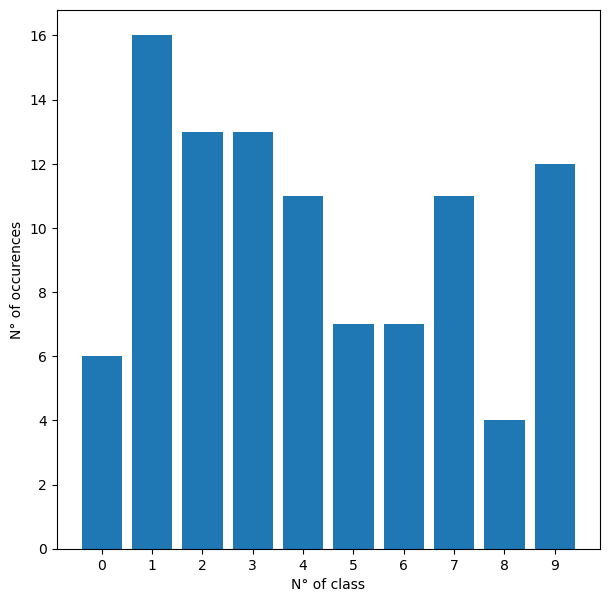

In [19]:
Class=np.zeros(10)
for _, label in first_100:
    Class[label] += 1

plt.figure(figsize=(7,7))
plt.bar([i for i in range(10)], Class)
plt.xlabel("N° of class")
plt.ylabel("N° of occurences")
plt.xticks([i for i in range(10)])

# The Baseline

In this section, the goal is to train a CNN on $\mathcal{X}_{\text{train}}$ and compare its performance with reported numbers from the litterature. You will have to re-use and/or design a standard classification pipeline. You should optimize your pipeline to obtain the best performances (image size, data augmentation by flip, ...).

The key ingredients for training a CNN are the batch size, as well as the learning rate scheduler (i.e. how to decrease the learning rate as a function of the number of epochs). A possible scheduler is to start the learning rate at 0.1 and decreasing it every 30 epochs by 10. In case of divergence, reduce the learning rate. A potential batch size could be 10, yet this can be cross-validated.

You can get some baselines accuracies in this paper (obviously, it is a different context for those researchers who had access to GPUs!) : http://openaccess.thecvf.com/content_cvpr_2018/papers/Keshari_Learning_Structure_and_CVPR_2018_paper.pdf. 

## ResNet architectures

__Question 3 (2 points) :__ Write a classification pipeline for $\mathcal{X}_{\text{train}}$, train from scratch and evaluate a *ResNet-18* architecture specific to CIFAR10 (details about the ImageNet model can be found here: https://arxiv.org/abs/1512.03385). Please report the accuracy obtained on the whole dataset as well as the reference paper/GitHub link.

*Hint :* You can re-use the following code : https://github.com/kuangliu/pytorch-cifar. During a training of 10 epochs, a batch size of 10 and a learning rate of 0.01, one obtains 40% accuracy on $\mathcal{X}_{\text{train}}$ (\~2 minutes) and 20% accuracy on $\mathcal{X}_{\text{test}}$ (\~5 minutes).

### printing

In [3]:
def format_time(seconds):
    days = int(seconds / 3600/24)
    seconds = seconds - days*3600*24
    hours = int(seconds / 3600)
    seconds = seconds - hours*3600
    minutes = int(seconds / 60)
    seconds = seconds - minutes*60
    secondsf = int(seconds)
    seconds = seconds - secondsf
    millis = int(seconds*1000)

    f = ''
    i = 1
    if days > 0:
        f += str(days) + 'D'
        i += 1
    if hours > 0 and i <= 2:
        f += str(hours) + 'h'
        i += 1
    if minutes > 0 and i <= 2:
        f += str(minutes) + 'm'
        i += 1
    if secondsf > 0 and i <= 2:
        f += str(secondsf) + 's'
        i += 1
    if millis > 0 and i <= 2:
        f += str(millis) + 'ms'
        i += 1
    if f == '':
        f = '0ms'
    return f

def progress_bar(current, total, msg=None):
    global last_time, begin_time
    if current == 0:
        begin_time = time.time()  # Reset for new bar.

    cur_len = int(TOTAL_BAR_LENGTH*current/total)
    rest_len = int(TOTAL_BAR_LENGTH - cur_len) - 1

    sys.stdout.write(' [')
    for i in range(cur_len):
        sys.stdout.write('=')
    sys.stdout.write('>')
    for i in range(rest_len):
        sys.stdout.write('.')
    sys.stdout.write(']')

    cur_time=time.time()
    step_time=cur_time - last_time
    last_time=cur_time
    tot_time=cur_time - begin_time

    L = []
    L.append('  Step: %s' % format_time(step_time))
    L.append(' | Tot: %s' % format_time(tot_time))
    if msg:
        L.append(' | ' + msg)

    msg = ''.join(L)
    sys.stdout.write(msg)
    for i in range(3-int(TOTAL_BAR_LENGTH)-len(msg)-3):
        sys.stdout.write(' ')

    # Go back to the center of the bar.
    for i in range(3-int(TOTAL_BAR_LENGTH/2)+2):
        sys.stdout.write('\b')
    sys.stdout.write(' %d/%d ' % (current+1, total))

    if current<total-1:
        sys.stdout.write('\r')
    else:
        sys.stdout.write('\n')
    sys.stdout.flush()

In [89]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes) #Batch normalization
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes) #Batch normalization

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) #residual connection
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0),-1)
        out = self.linear(out)
        return out

: 

### Training

In [449]:
criterion=nn.CrossEntropyLoss()
nb_epoch=10
TOTAL_BAR_LENGTH = 65.
last_time=time.time()
begin_time=last_time

def train(model, nb_epoch, optimizer, scheduler, criterion, train_loader, device, verbose=True):
    print("Training phase...")
    training_loss=[]
    accuracy=[]
    model=model.to(device)
    model.train()
    for epoch in range(nb_epoch):
        correct = 0
        total = 0
        train_loss=0

        loss=0
        for batch_idx, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss+=loss.item()
            predicted=torch.argmax(outputs, axis=1) #Class predicted
            total+=targets.size(0)
            correct+=torch.count_nonzero(predicted==targets)

        if verbose and epoch%5==0 or epoch==0 or epoch==nb_epoch-1:
            print(f"At epoch {epoch}, Train loss: {train_loss/len(train_loader)}, Accuracy: {correct/total*100}%.")

        training_loss.append(train_loss/len(train_loader))
        accuracy.append(100.*correct/total)

    return training_loss, accuracy

def test(model, criterion, test_loader, device, verbose=True):
    print("Test phase...")
    global best_acc
    model.eval()
    test_loss=0
    correct=0
    total=0
    accuracy=[]

    with torch.no_grad(): #deactivate the computational graph
        for batch_idx, (inputs, targets) in enumerate(test_loader):
            inputs, targets=inputs.to(device), targets.to(device)
            outputs=model(inputs)
            loss=criterion(outputs, targets)

            test_loss+=loss.item()
            predicted = torch.argmax(outputs, axis=1)
            total += len(targets)
            correct += torch.count_nonzero(predicted==targets)

        accuracy.append(100*correct/total)
        if verbose:
            print(f"The loss test {test_loss/len(test_loader)}.")
            print(f"The accuracy is {correct/total*100}%.")

Training phase...
At epoch 0, Train loss: 2.637135910987854, Accuracy: 22.0%.
At epoch 5, Train loss: 0.9875750541687012, Accuracy: 65.0%.
At epoch 10, Train loss: 0.5391306579113007, Accuracy: 82.0%.
At epoch 15, Train loss: 0.07443472379818558, Accuracy: 98.0%.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


At epoch 19, Train loss: 0.007938638760242612, Accuracy: 100.0%.
--------------------------------
Test phase...
The loss test 3.6607127521038056.
The accuracy is 23.68000030517578%.


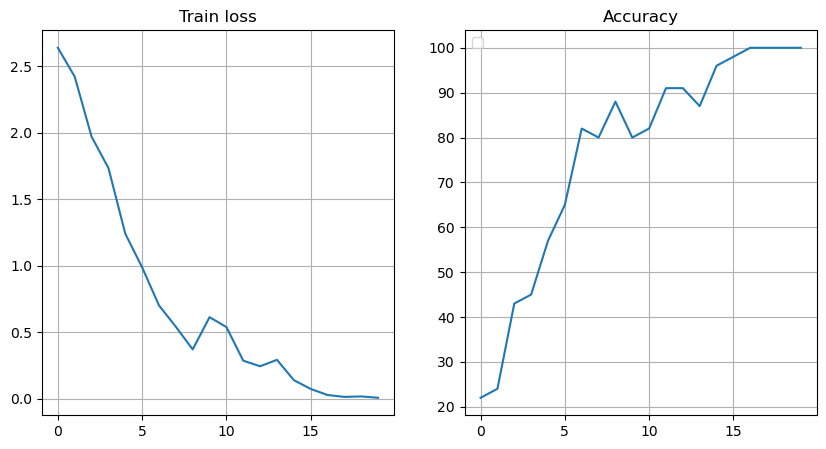

In [450]:
net=ResNet(BasicBlock, [2, 2, 2, 2])
optimizer=optim.SGD(net.parameters(), lr=0.01, momentum=.8) #Recall that net.parameters is a generator over all the model's weights.
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
training_loss, accuracy = train(net, 20, optimizer, scheduler, criterion, dataloader_train, device)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(training_loss)
ax[0].title.set_text("Train loss")
ax[1].plot(accuracy)
ax[1].title.set_text("Accuracy")
ax[0].grid("on")
ax[1].grid("on")
plt.legend()
print("--------------------------------")
test(net, criterion, dataloader_test, device)

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RESNET18  | 10 | 100% | 25% |


# Transfer learning

We propose to use pre-trained models on a classification and generative task, in order to improve the results of our setting.

In our set of experiments, we will be loading ResNet-18, ResNet-34 and ResNet-50 weights as our baseline model.

## ImageNet features

Now, we will use some pre-trained models on ImageNet and see how well they compare on CIFAR. A list is available on : https://pytorch.org/vision/stable/models.html.

__Question 4 (1 points):__ Pick a model from the list above, adapt it for CIFAR10 and retrain its final layer (or a block of layers, depending on the resources to which you have access to). Report its accuracy.

To train the model, the following strategy is adopted. In a first phase, one trains the very last fc layer. In the next phase, all layers are trained except for the last one. In the last phase, all layers are trained at the same time.

In [236]:
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.models import resnet34, ResNet34_Weights
from torchvision.models import resnet50, ResNet50_Weights

In [440]:
class Net(nn.Module):
    def __init__(self, version):
        super().__init__()

        self.version=version

        if version=='ResNet-18':
            model=resnet18(weights=ResNet18_Weights.DEFAULT)
        elif version=='ResNet-34':
            model=resnet34(weights=ResNet34_Weights.DEFAULT)
        elif version=='ResNet-50':
            model=resnet50(weights=ResNet50_Weights.DEFAULT)
        else:
            print("No model exists for " + version)

        self.layers=list(model.children())
        self.input_dim=self.layers[-1].in_features
        self.layers=self.layers[:-1]#Remove the very last fc layer
        self.layers=nn.Sequential(*self.layers)
        self.last_layer=nn.Linear(self.input_dim, 10)

    def forward(self,x):
        x=self.layers(x)
        x=x.squeeze() #Squeeze the tensor to remove extra dimensions.
        x=self.last_layer(x)
        return x

Training phase...
At epoch 0, Train loss: 2.7010403633117677, Accuracy: 9.0%.
At epoch 5, Train loss: 1.887126123905182, Accuracy: 37.0%.
At epoch 10, Train loss: 1.51776065826416, Accuracy: 52.0%.
At epoch 14, Train loss: 1.4485798060894013, Accuracy: 52.0%.
Training phase...
At epoch 0, Train loss: 1.3401062130928039, Accuracy: 60.000003814697266%.
At epoch 5, Train loss: 0.4076740324497223, Accuracy: 90.0%.
At epoch 10, Train loss: 0.32970465794205667, Accuracy: 91.0%.
At epoch 15, Train loss: 0.1983288496732712, Accuracy: 94.0%.
At epoch 20, Train loss: 0.13570704218000174, Accuracy: 97.0%.
At epoch 25, Train loss: 0.09707627408206462, Accuracy: 98.0%.
At epoch 29, Train loss: 0.14079584553837776, Accuracy: 98.0%.
Training phase...
At epoch 0, Train loss: 0.08340910617262125, Accuracy: 99.0%.
At epoch 5, Train loss: 0.13793546818196772, Accuracy: 98.0%.
At epoch 10, Train loss: 0.047778947139158846, Accuracy: 99.0%.
At epoch 15, Train loss: 0.024180209916085004, Accuracy: 100.0%.
A

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The loss test 2.7470828610658646.
The accuracy is 29.499998092651367%.


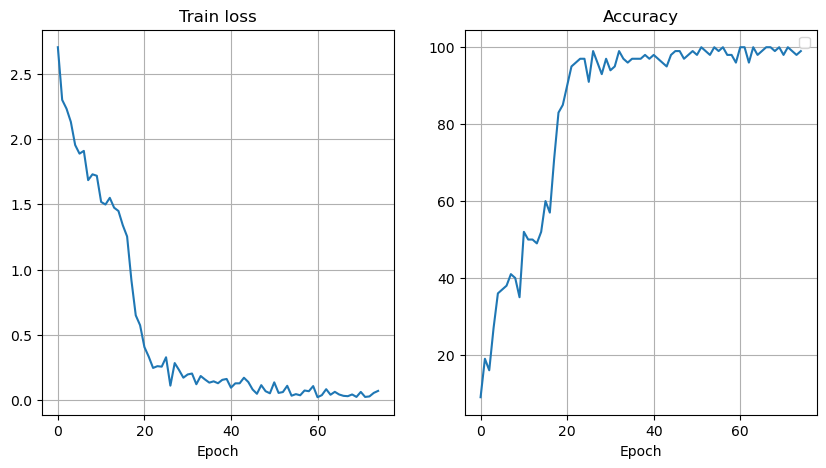

In [451]:
version="ResNet-18"
net=Net(version)
optimizer=optim.SGD(net.parameters(), lr=1e-3, momentum=.8)
scheduler=optim.lr_scheduler.StepLR(optimizer, 10, 0.95)
criterion=nn.CrossEntropyLoss()
def train_model(model, optimizer, scheduler, criterion, train_loader, device):

    #Make backpropagation non possible through the block layers
    for param in model.layers.parameters():
        param.requires_grad=False

    training_loss1, accuracy1 = train(model, 15, optimizer, scheduler, criterion, train_loader, device)
    #====================================================================================
    for param in model.layers.parameters():
        param.requires_grad=True
    for param in model.last_layer.parameters():
        param.requires_grad=False

    training_loss2, accuracy2 = train(model, 30, optimizer, scheduler, criterion, train_loader, device)
    #====================================================================================

    training_loss=np.concatenate((training_loss1, training_loss2), axis=0)
    accuracy=np.concatenate((accuracy1, accuracy2), axis=0)
    return training_loss, accuracy

training_loss, accuracy=train_model(net, optimizer, scheduler, criterion, dataloader_train, device)
test(net, criterion, dataloader_test, device)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(training_loss)
ax[0].title.set_text("Train loss")
ax[0].set_xlabel("Epoch")
ax[1].plot(accuracy)
ax[1].title.set_text("Accuracy")
ax[1].set_xlabel("Epoch")
ax[0].grid("on")
ax[1].grid("on")
plt.legend()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RESNET18  | 75 | 100% | 30% |


Training phase...
At epoch 0, Train loss: 2.6459716081619264, Accuracy: 9.0%.
At epoch 5, Train loss: 1.4760174036026001, Accuracy: 52.999996185302734%.
At epoch 10, Train loss: 1.3552735030651093, Accuracy: 64.0%.
At epoch 14, Train loss: 1.1067225992679597, Accuracy: 64.0%.
Training phase...
At epoch 0, Train loss: 1.004366970062256, Accuracy: 71.0%.
At epoch 5, Train loss: 0.369318637624383, Accuracy: 88.0%.
At epoch 10, Train loss: 0.3066472848877311, Accuracy: 90.0%.
At epoch 15, Train loss: 0.1202322693541646, Accuracy: 97.0%.
At epoch 20, Train loss: 0.20248549729585646, Accuracy: 94.0%.
At epoch 25, Train loss: 0.0815365720540285, Accuracy: 97.0%.
At epoch 29, Train loss: 0.030583341792225837, Accuracy: 99.0%.
Training phase...
At epoch 0, Train loss: 0.05495760275516659, Accuracy: 98.0%.
At epoch 5, Train loss: 0.05325131006538868, Accuracy: 98.0%.
At epoch 10, Train loss: 0.06473444239236414, Accuracy: 98.0%.
At epoch 15, Train loss: 0.06983483209041878, Accuracy: 97.0%.
At e

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The loss test 3.041460988342762.
The accuracy is 32.0%.


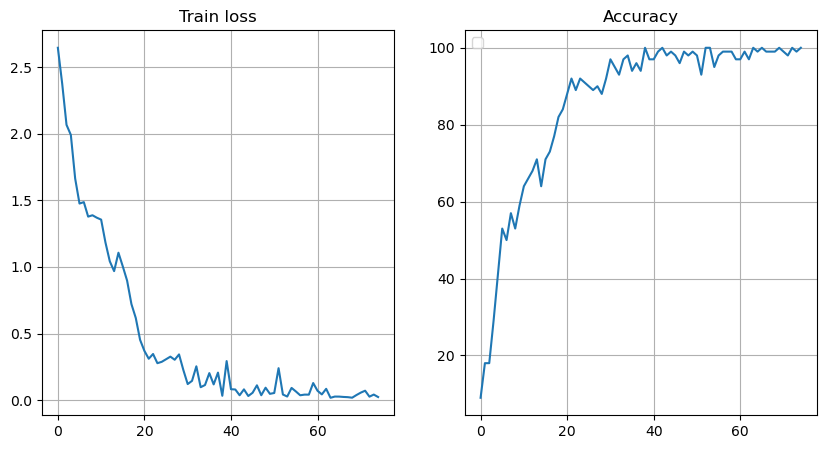

In [452]:
version="ResNet-34"
net=Net(version)
optimizer=optim.SGD(net.parameters(), lr=1e-3, momentum=.9)
scheduler=optim.lr_scheduler.StepLR(optimizer, 10,0.95)
criterion=nn.CrossEntropyLoss()

training_loss, accuracy=train_model(net, optimizer, scheduler, criterion, dataloader_train, device)
test(net, criterion, dataloader_test, device)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(training_loss)
ax[0].title.set_text("Train loss")
ax[1].plot(accuracy)
ax[1].title.set_text("Accuracy")
ax[0].grid("on")
ax[1].grid("on")
plt.legend()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RESNET34  | 75 | 100% | 32% |


Training phase...
At epoch 0, Train loss: 2.2803102493286134, Accuracy: 10.0%.
At epoch 5, Train loss: 1.5339870214462281, Accuracy: 49.0%.
At epoch 10, Train loss: 1.3689616084098817, Accuracy: 51.0%.
At epoch 14, Train loss: 1.4170542359352112, Accuracy: 58.0%.
Training phase...
At epoch 0, Train loss: 2.361773872375488, Accuracy: 31.0%.
At epoch 5, Train loss: 2.128413999080658, Accuracy: 22.0%.
At epoch 10, Train loss: 1.8654799222946168, Accuracy: 39.0%.
At epoch 15, Train loss: 1.6333581924438476, Accuracy: 51.0%.
At epoch 20, Train loss: 1.4118019700050355, Accuracy: 52.0%.
At epoch 25, Train loss: 0.9908117651939392, Accuracy: 71.0%.
At epoch 29, Train loss: 1.0402504593133926, Accuracy: 67.0%.
Training phase...
At epoch 0, Train loss: 0.839579725265503, Accuracy: 72.0%.
At epoch 5, Train loss: 1.2764430582523345, Accuracy: 58.999996185302734%.
At epoch 10, Train loss: 0.9288968563079834, Accuracy: 74.0%.
At epoch 15, Train loss: 0.5237552285194397, Accuracy: 83.0%.
At epoch 20

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


The loss test 4.541125861525535.
The accuracy is 20.540000915527344%.


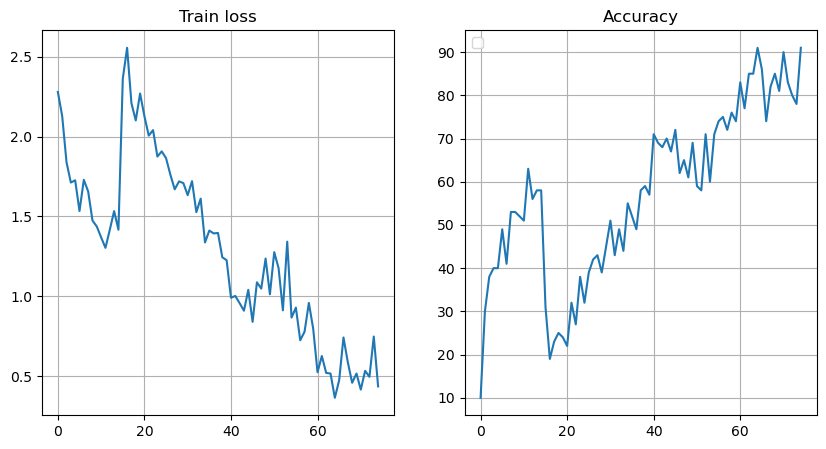

In [453]:
version="ResNet-50"
net=Net(version)
optimizer=optim.SGD(net.parameters(), lr=1e-2, momentum=.9)
scheduler=optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=10, gamma=0.95)
criterion=nn.CrossEntropyLoss()
training_loss, accuracy=train_model(net, optimizer, scheduler, criterion, dataloader_train, device)
test(net, criterion, dataloader_test, device)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(training_loss)
ax[0].title.set_text("Train loss")
ax[1].plot(accuracy)
ax[1].title.set_text("Accuracy")
ax[0].grid("on")
ax[1].grid("on")
plt.legend()

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RESNET50  | 75 | 100% | 20% |


# Incorporating *a priori*
Geometrical *a priori* are appealing for image classification tasks, though one might have to handle several boundary effects.

__Question 5 (0.5 points) :__ Explain the issues when dealing with translations, rotations, scaling effects, color changes on $32\times32$ images. Propose several ideas to tackle them.

- Translation: Consists in translating the pixels of an image in a direction $a \in \mathbb{R}^2$. Formally, it sets $\mathcal{T}[x](u)=x(u - a)$. 
    - $\textbf{Problem}$: by construction, certain pixels $u$ are such that $u-a \notin x$. They do not have antecendent by the translation operator, so no pixels are assigned to them. By default, they are assigned the value 0, but it heavily corrupts the original image, as an entire set of pixels becomes uninformative.
    - $\textbf{Solution}$: You can consider periodic boundary conditions, e.g., top-row pixels translates to the bottom-row line. No information is lost in this manner.

- Rotation. Apply a rotation matrix $R(\theta)$ to the image, i.e., take $\mathcal{T}[x](u)=x(R^{-1}u)$.
    - $\textbf{Problem}$: This transformation can be ill-defined in a cartesian fixed grid, especially for pixels located around corners and edges.
    - $\textbf{Solution}$: This issue can be circumvented if we accept to use interpolations to replace missing pixels.

- Scaling effects. Image scaling involves resizing an image to a desired size.
    - $\textbf{Problem}$: It can be challenging to keep an image well-structured, and not create any visual aberration.
    - $\textbf{Solution}$: We can once again use interpolation to balance for the lost information in the process (linear, quadratic, cubic...)

- Color changes. Change the pixel's intensity for each color channel.
    - $\textbf{Problem}$: The RGB colorbase is highly correlated, so the colors can not be changed independently to keep a coherent image.
    - $\textbf{Solution}$: Use an other color base, the more famous being HSV (pour teinte, saturation, valeur), because it splits apart color information from intensity. Only intensity components are modified.

## Data augmentations

__Question 6 (4 points):__ Propose a set of geometric transformation beyond translation, and incorporate them in your training pipeline. Train the model of the __Question 3__ with them and report the accuracies.

From the Web page https://pytorch.org/vision/main/transforms.html, we can cite:
- <code>RandomHorizontalFlip</code> Flip horizontaly an image at a given probability, by default 1/2.
- <code>RandomAffine</code> Random affine transformation of the image keeping center invariant.
- <code>ColorJitter</code> Randomly change the brightness, contrast, saturation and hue of an image or video.
- <code>GaussianBlur</code> Apply a blur gaussian filter on the image.

A last normalization step is mandatory.

In [476]:
transform_train=v2.Compose([
    v2.RandomHorizontalFlip(1/2),
    v2.RandomCrop(size=[32,32], padding=3),
    v2.GaussianBlur(kernel_size=3),
    v2.ColorJitter(hue=.1),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_test=v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

#Import the training dataset
trainset=datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

#Take only first hundred element
first_100=Subset(trainset, indices=list(np.arange(100)))

#Import the test dataset
testset=datasets.CIFAR10(root="./data", train=False, download=True, transform=transform_test)

#Declare dataloaders.
dataloader_train=DataLoader(first_100, batch_size=10, shuffle=True)
dataloader_test=DataLoader(testset, batch_size=10, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


### On user-defined model

Training phase...
At epoch 0, Train loss: 2.474674415588379, Accuracy: 10.0%.
At epoch 5, Train loss: 2.206287157535553, Accuracy: 26.0%.
At epoch 10, Train loss: 1.640628981590271, Accuracy: 46.0%.
At epoch 15, Train loss: 1.475126177072525, Accuracy: 44.0%.
At epoch 20, Train loss: 1.0500418424606324, Accuracy: 60.000003814697266%.
At epoch 25, Train loss: 0.9479657143354416, Accuracy: 73.0%.
At epoch 30, Train loss: 0.8772077351808548, Accuracy: 71.0%.
At epoch 35, Train loss: 0.7737536609172821, Accuracy: 75.0%.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


At epoch 39, Train loss: 0.8159740805625916, Accuracy: 72.0%.
--------------------------------
Test phase...
The loss test 4.746077877640724.
The accuracy is 22.719999313354492%.


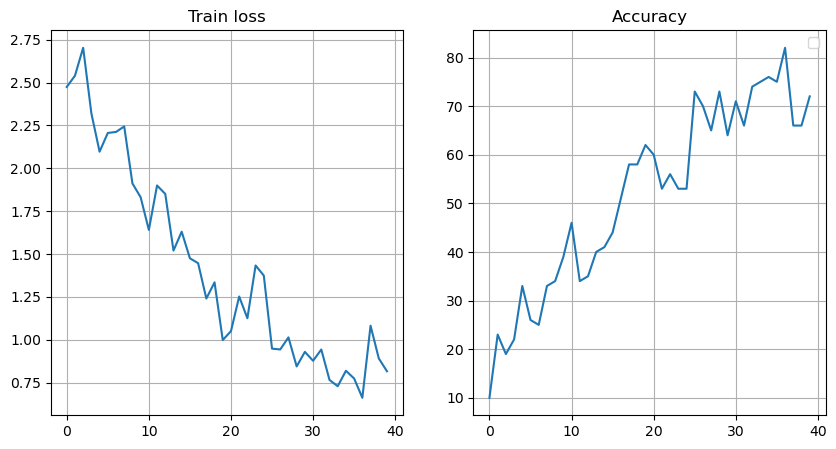

In [471]:
net=ResNet(BasicBlock, [2, 2, 2, 2])
optimizer=optim.SGD(net.parameters(), lr=1e-2, momentum=.8) #Recall that net.parameters is a generator over all the model's weights.
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
training_loss, accuracy = train(net, 40, optimizer, scheduler, criterion, dataloader_train, device)

fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].plot(training_loss)
ax[0].title.set_text("Train loss")
ax[1].plot(accuracy)
ax[1].title.set_text("Accuracy")
ax[0].grid("on")
ax[1].grid("on")
plt.legend()
print("--------------------------------")
test(net, criterion, dataloader_test, device)

### On pretrained modeles

In [477]:
version="ResNet-18"
net=Net(version)
optimizer=optim.SGD(net.parameters(), lr=1e-2)
lr_scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)
criterion=nn.CrossEntropyLoss()

training_loss, accuracy=train_model(net, optimizer, scheduler, criterion, dataloader_train, device)
test(net, criterion, dataloader_test, device)

Training phase...
At epoch 0, Train loss: 2.5349738359451295, Accuracy: 15.000000953674316%.
At epoch 5, Train loss: 2.2939552426338197, Accuracy: 22.0%.
At epoch 10, Train loss: 1.9156112909317016, Accuracy: 32.0%.
At epoch 14, Train loss: 1.9131115913391112, Accuracy: 34.0%.
Training phase...
At epoch 0, Train loss: 2.022045397758484, Accuracy: 35.0%.
At epoch 5, Train loss: 1.7411083102226257, Accuracy: 40.0%.
At epoch 10, Train loss: 1.1883550137281418, Accuracy: 58.999996185302734%.
At epoch 15, Train loss: 0.9171932160854339, Accuracy: 69.0%.
At epoch 20, Train loss: 0.731964698433876, Accuracy: 73.0%.
At epoch 25, Train loss: 0.47849862426519396, Accuracy: 83.0%.
At epoch 29, Train loss: 0.4147929459810257, Accuracy: 85.0%.
Training phase...
At epoch 0, Train loss: 0.3804628074169159, Accuracy: 89.0%.
At epoch 5, Train loss: 0.4000993125140667, Accuracy: 88.0%.
At epoch 10, Train loss: 0.38119196221232415, Accuracy: 87.0%.
At epoch 15, Train loss: 0.23272739052772523, Accuracy: 

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RESNET18  | 75 | 100% | 30% |

In [475]:
version="ResNet-34"
net=Net(version)
optimizer=optim.ASGD(net.parameters(), lr=1e-2)
lr_scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

criterion=nn.CrossEntropyLoss()

training_loss, accuracy=train_model(net, optimizer, scheduler, criterion, dataloader_train, device)
test(net, criterion, dataloader_test, device)

Training phase...
At epoch 0, Train loss: 2.68215274810791, Accuracy: 5.0%.
At epoch 5, Train loss: 1.75688134431839, Accuracy: 36.0%.
At epoch 10, Train loss: 1.3033543169498443, Accuracy: 57.0%.
At epoch 14, Train loss: 0.9072732031345367, Accuracy: 70.0%.
Training phase...
At epoch 0, Train loss: 1.6103597700595855, Accuracy: 46.0%.
At epoch 5, Train loss: 0.5904262572526932, Accuracy: 82.0%.
At epoch 10, Train loss: 0.15706266090273857, Accuracy: 95.0%.
At epoch 15, Train loss: 0.22021790123544632, Accuracy: 93.0%.
At epoch 20, Train loss: 0.1520249065477401, Accuracy: 95.0%.
At epoch 25, Train loss: 0.07530479440465569, Accuracy: 98.0%.
At epoch 29, Train loss: 0.08803370650857686, Accuracy: 97.0%.
Training phase...
At epoch 0, Train loss: 0.054660447500646116, Accuracy: 100.0%.
At epoch 5, Train loss: 0.12678661653771997, Accuracy: 94.0%.
At epoch 10, Train loss: 0.049252347485162315, Accuracy: 99.0%.
At epoch 15, Train loss: 0.05795361469499767, Accuracy: 98.0%.
At epoch 20, Tra

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RESNET34  | 75 | 100% | 29.6% |

In [479]:
version="ResNet-50"
net=Net(version)
optimizer=optim.SGD(net.parameters(), lr=1e-2)
lr_scheduler=optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

criterion=nn.CrossEntropyLoss()

training_loss, accuracy=train_model(net, optimizer, scheduler, criterion, dataloader_train, device)
test(net, criterion, dataloader_test, device)

Training phase...
At epoch 0, Train loss: 2.3802125453948975, Accuracy: 5.0%.
At epoch 5, Train loss: 2.235543894767761, Accuracy: 16.0%.
At epoch 10, Train loss: 2.2067065119743345, Accuracy: 18.0%.
At epoch 14, Train loss: 2.0749240040779116, Accuracy: 29.0%.
Training phase...
At epoch 0, Train loss: 2.0563939809799194, Accuracy: 22.0%.
At epoch 5, Train loss: 2.1372081875801086, Accuracy: 23.0%.
At epoch 10, Train loss: 2.1310588479042054, Accuracy: 19.0%.
At epoch 15, Train loss: 1.96625554561615, Accuracy: 32.0%.
At epoch 20, Train loss: 1.8875111222267151, Accuracy: 31.0%.
At epoch 25, Train loss: 1.890072226524353, Accuracy: 43.0%.
At epoch 29, Train loss: 1.8849977016448975, Accuracy: 33.0%.
Training phase...
At epoch 0, Train loss: 1.8445378184318542, Accuracy: 37.0%.
At epoch 5, Train loss: 1.7055524468421936, Accuracy: 45.0%.
At epoch 10, Train loss: 1.4659594178199769, Accuracy: 49.0%.
At epoch 15, Train loss: 1.2977971076965331, Accuracy: 63.0%.
At epoch 20, Train loss: 1.

| Model | Number of  epochs  | Train accuracy | Test accuracy |
|------|------|------|------|
|   RESNET50  | 75 | 72% | 29.5% |

# Conclusions

__Question 7 (3 points) :__ Write a short report explaining the pros and the cons of each method that you implemented. 25% of the grade of this project will correspond to this question, thus, it should be done carefully. In particular, please add a plot that will summarize all your numerical results.

# Weak supervision

__Bonus \[open\] question (up to 3 points) :__ Pick a weakly supervised method that will potentially use $\mathcal{X}\cup\mathcal{X}_{\text{train}}$ to train a representation (a subset of $\mathcal{X}$ is also fine). Evaluate it and report the accuracies. You should be careful in the choice of your method, in order to avoid heavy computational effort.